In [21]:
import torch
from torch.autograd import Variable
import shap
import numpy
import pandas
import argparse
import os 
from typing import Any, Dict, List
import pandas as pd
from torch.nn import MSELoss, L1Loss
import numpy as np
import json 
import random
from tqdm import tqdm
from pathlib import Path
from scipy.stats import binned_statistic
import matplotlib.pylab as plt
from torch_frame.data.stats import StatType, compute_col_stats

import torch

import torch_frame
from torch.nn import Linear, Module
from torch_frame.data import Dataset
from torch_frame.data import DataLoader
from torch_frame import TensorFrame, stype
from torch_frame.nn.models.ft_transformer import FTTransformer
from torch.nn import Linear, Module, ModuleList
from typing import Any, Dict, List
from torch import Tensor
import torch 

import torch_frame
from torch_frame import TensorFrame, stype
from torch_frame.data.stats import StatType
from torch_frame.nn.conv import TabTransformerConv, FTTransformerConvs
from torch_frame.nn.encoder import (
    EmbeddingEncoder,
    LinearEncoder,
    LinearEmbeddingEncoder,
    StypeWiseFeatureEncoder,
    MultiCategoricalEmbeddingEncoder,
    TimestampEncoder,
)

import sys
sys.path.append('../modeling/')

from model import TabTransformer, FTTransformer, stype_encoder_dict_2, stype_encoder_dict_3
from train import get_args_parser

In [2]:
# model_weight = torch.load("../model_checkpoints/tabformer_t41a2/model_epoch_010.pth")
# model_weight

In [3]:
# model_weight = torch.load("../model_checkpoints/tabformer_t41a1/model_epoch_020.pth")
# model_weight

In [44]:
target = "price"
dense_features = ["LON", 
                "LAT", 
                "building_sqft", 
                "Lot Size", 
                "Year Built", 
                "Garage Number", 
                "Bedrooms", 
                "Baths", 
                "Maintenance Fee", 
                "Tax Rate", 
                "Recent Market Value", 
                "Recent Tax Value", 
                 "index"]
cate = ["status", "Property Type", "County", "Private Pool", "Area Pool"]
time_col = ["date"]
cate_multi = ["Foundation_multiclass", "Garage Types_multiclass", 
            "Roof Type_multiclass", "Pool_feature_multiclass", "floor_type_multiclass", 
            "finance_option_multiclass", "Exterior Type_multiclass", "Style_multiclass"]

add_numerial_features = ["elementary_school_star", "middle_school_star", "high_school_star"]
add_cate_multi = ["school_org"] # ["school_names", "school_grades", "school_org"]
text_embedding_col = ["general_desc_roberta_mean_features"]
img_embedding_col = ["img_emb"]
raw_df = pd.read_pickle("../data/property_structured_12162024.pkl").reset_index(drop=True)
raw_df["index"] = np.arange(len(raw_df))
raw_df["date"] = raw_df["date"].apply(lambda x: x.replace("_", "-"))
dense_features = dense_features + add_numerial_features
cate_multi = cate_multi + add_cate_multi

for feat in dense_features:
    raw_df[feat] = raw_df[feat].fillna(raw_df[feat].mean())

col_to_stype = {}
col_to_stype.update({d: stype.numerical for d in dense_features})
col_to_stype.update({d: stype.timestamp for d in time_col})
col_to_stype.update({target: stype.numerical})
col_to_stype.update({d: stype.categorical for d in cate})
col_to_stype.update({d: stype.multicategorical for d in cate_multi})
raw_df = raw_df[dense_features + cate + cate_multi + time_col + [target]]
stype_encoder_dict = stype_encoder_dict_2

for col in cate_multi:
    raw_df[col] = raw_df[col].apply(lambda d: d if isinstance(d, list) else [])

dataset = Dataset(
    raw_df, 
    col_to_stype=col_to_stype,
    target_col="price"
)
dataset.materialize()
torch.manual_seed(10)
dataset.shuffle()
train_dataset, val_dataset = dataset[:0.8], dataset[0.80:]

-96.126886 47.20818
1


(<Axes: >,)

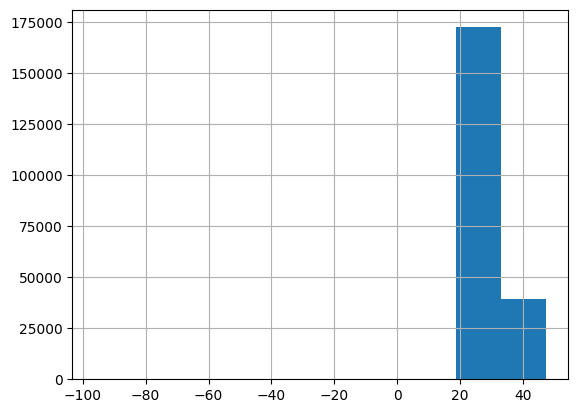

In [14]:
print(raw_df["LON"].min(), raw_df["LON"].max())
print(np.sum(raw_df["LON"] < 0))
raw_df["LON"].hist(), 

In [16]:
raw_df[raw_df["LAT"] > 0][["LON", "LAT"]]

,LON,LAT
3627,29.394620,95.137700
8769,29.804015,95.854015
18608,29.831090,95.461080
29888,30.644170,97.817600
30532,33.283723,96.884628
48999,33.251870,96.939500
53271,29.892296,29.892296
72655,30.145396,97.706595
91047,30.336841,97.382548
91721,33.283400,97.158820


-116.75112 98.02321
22


<Axes: >

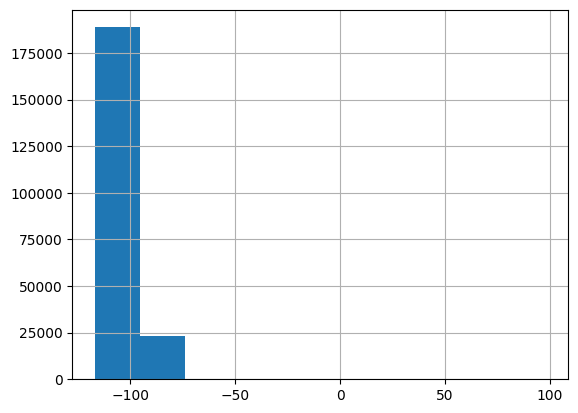

In [15]:
print(raw_df["LAT"].min(), raw_df["LAT"].max())
print(np.sum(raw_df["LAT"] > 0))
raw_df["LAT"].hist()

In [5]:
tf = train_dataset.tensor_frame
stype = tf.stypes[-1]
tf.feat_dict[stype][0]

tensor([[2023,   10,    4,    6,    0,    0,    0]])

In [45]:
from copy import deepcopy 
col_to_stype["LON"]

<stype.numerical: 'numerical'>

In [60]:
col_stats = deepcopy(train_dataset._col_stats)
del col_stats["LON"][StatType.stats_for_stype(col_to_stype["LON"])[0]]

In [61]:
col_stats["LON"]

{<StatType.STD: 'STD'>: 1.446449760073221,
 <StatType.QUANTILES: 'QUANTILES'>: [-96.126886,
  29.74322875,
  30.1612985,
  32.69397725,
  47.20818]}

In [69]:
# for col_, stype_ in col_to_stype.items():
#     assert col_ in col_stats, f"{col_} is not specified in the provided col_stats"
#     stats_ = col_stats[col_]
#     assert np.all([key_ in stats_ for key_ in StatType.stats_for_stype(stype_)]), \
#     f"not all required stats are calculated in the provided col_stats for {col}"
#     # assert np.any([key_ in stats_ for key_ in StatType.stats_for_stype(stype_)]), "test"
    

In [68]:
stats_ = col_stats["LON"]
stype_ = col_to_stype["LON"]
all([key_ in stats_ for key_ in StatType.stats_for_stype(stype_)])

False

In [4]:
import pickle
with open('../model_checkpoints/tabformer_t32c/col_to_stype.pkl', 'wb') as fp:
    pickle.dump(col_to_stype, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [3]:
train_loader = DataLoader(train_dataset.tensor_frame, 
                          batch_size=1024,
                          shuffle=True)
train_iter = iter(train_loader)
train_loader.tensor_frame

TensorFrame(
  num_cols=30,
  num_rows=169568,
  numerical (15): ['Baths', 'Bedrooms', 'Garage Number', 'LAT', 'LON', 'Lot Size', 'Maintenance Fee', 'Recent Market Value', 'Recent Tax Value', 'Tax Rate', 'Year Built', 'building_sqft', 'elementary_school_star', 'high_school_star', 'middle_school_star'],
  timestamp (1): ['date'],
  categorical (5): ['Area Pool', 'County', 'Private Pool', 'Property Type', 'status'],
  multicategorical (9): ['Exterior Type_multiclass', 'Foundation_multiclass', 'Garage Types_multiclass', 'Pool_feature_multiclass', 'Roof Type_multiclass', 'Style_multiclass', 'finance_option_multiclass', 'floor_type_multiclass', 'school_org'],
  has_target=True,
  device='cpu',
)

In [56]:
dataset.col_stats["Property Type"][StatType.COUNT]

(['single family',
  'townhouse/condo',
  'residential/condo',
  'townhouse',
  'mid/hi-rise condo',
  'country homes/acreage',
  'residential/mobile home',
  'multi-family',
  'residential/manufactured',
  '',
  'residential',
  'residential/lot',
  'residential - modular',
  'farm',
  'farm - manufactured home',
  'lots',
  'land / unimproved land'],
 [193184,
  6513,
  4842,
  2958,
  848,
  514,
  409,
  342,
  326,
  104,
  57,
  20,
  10,
  7,
  2,
  1,
  1])

<StatType.COUNT: 'COUNT'>

In [4]:
def load_argparse(filename):
    with open(filename, "r") as f:
        args = json.load(f)
    return args

args = load_argparse("../model_checkpoints/tabformer_t90/config.cfg")
args

model = TabTransformer(
        channels=args["tabformer_channels"],
        num_layers=args["tabformer_num_layers"],
        num_heads=args["tabformer_num_heads"],
        col_stats=train_dataset.col_stats,
        col_names_dict=train_dataset.tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict, 
).to("cuda:0")

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
loss_fn = MSELoss()

In [6]:
model.state_dict()["encoder.encoder_dict.numerical.weight"][0]

tensor([-0.0123,  0.0067, -0.0096, -0.0017, -0.0086, -0.0094, -0.0008, -0.0128,
         0.0118, -0.0026,  0.0017,  0.0152, -0.0071, -0.0064, -0.0032, -0.0096,
        -0.0081, -0.0018,  0.0039, -0.0175,  0.0027,  0.0106,  0.0100, -0.0031,
         0.0127,  0.0085,  0.0023,  0.0105,  0.0239,  0.0083, -0.0177,  0.0051],
       device='cuda:0')

In [7]:
losses = []

In [13]:
# with autograd.detect_anomaly():
for i in range(10):
    tf = next(train_iter)
    tf = tf.to("cuda:0", non_blocking=True)
    optimizer.zero_grad()
    pred = model(tf)
    # print(pred, tf.y)
    loss = loss_fn(pred, tf.y)
    # print(loss)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    losses[-1]

In [14]:
model.state_dict()["encoder.encoder_dict.numerical.weight"][0]

tensor([-0.0106,  0.0053, -0.0115, -0.0008, -0.0102, -0.0086, -0.0018, -0.0134,
         0.0118, -0.0039,  0.0001,  0.0147, -0.0085, -0.0060, -0.0021, -0.0106,
        -0.0093, -0.0005,  0.0037, -0.0166,  0.0044,  0.0126,  0.0109, -0.0034,
         0.0146,  0.0094,  0.0032,  0.0109,  0.0222,  0.0087, -0.0173,  0.0034],
       device='cuda:0')

In [19]:
train_tf = train_dataset.tensor_frame

In [21]:
feat = train_tf.feat_dict[train_tf.stypes[0]]

In [23]:
torch.max(feat)

tensor(nan)

In [30]:
x = torch.Tensor([[1, 2, 3]])
y = torch.Tensor([[1, 1], [2, 2], [3, 3]])
print(x.shape, y.shape)
torch.einsum("ij,jk->ijk", x, y)

torch.Size([1, 3]) torch.Size([3, 2])


tensor([[[1., 1.],
         [4., 4.],
         [9., 9.]]])

In [31]:
tf

TensorFrame(
  num_cols=30,
  num_rows=16,
  numerical (15): ['Baths', 'Bedrooms', 'Garage Number', 'LAT', 'LON', 'Lot Size', 'Maintenance Fee', 'Recent Market Value', 'Recent Tax Value', 'Tax Rate', 'Year Built', 'building_sqft', 'elementary_school_star', 'high_school_star', 'middle_school_star'],
  timestamp (1): ['date'],
  categorical (5): ['Area Pool', 'County', 'Private Pool', 'Property Type', 'status'],
  multicategorical (9): ['Exterior Type_multiclass', 'Foundation_multiclass', 'Garage Types_multiclass', 'Pool_feature_multiclass', 'Roof Type_multiclass', 'Style_multiclass', 'finance_option_multiclass', 'floor_type_multiclass', 'school_org'],
  has_target=True,
  device='cuda:0',
)

In [46]:
tf = next(train_iter)

In [57]:
col_names = model.encoder.col_names_dict[stype]

In [79]:
stype = tf.stypes[0]
feat = tf.feat_dict[stype].to("cuda:0")
linear_encoder = model.encoder.encoder_dict[stype.value]
# model.encoder.encoder_dict[stype.value](feat[2:3], col_names)

In [29]:
## Get the validation set address

In [48]:
# raw_df = pd.read_pickle("../data/property_structured_12162024.pkl").reset_index(drop=True)
# raw_df["index"] = np.arange(len(raw_df))
train_tf = train_dataset.tensor_frame
val_tf = val_dataset.tensor_frame
stype = val_tf.stypes[0]
val_tf.col_names_dict[stype]

['Baths',
 'Bedrooms',
 'Garage Number',
 'LAT',
 'LON',
 'Lot Size',
 'Maintenance Fee',
 'Recent Market Value',
 'Recent Tax Value',
 'Tax Rate',
 'Year Built',
 'building_sqft',
 'elementary_school_star',
 'high_school_star',
 'index',
 'middle_school_star']

In [49]:
val_indices = val_tf.feat_dict[stype][:, -2].clone().numpy().astype(np.int)
train_indices = train_tf.feat_dict[stype][:, -2].clone().numpy().astype(np.int)
val_indices

/tmp/ipykernel_2325/3813009141.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_indices = val_tf.feat_dict[stype][:, -2].clone().numpy().astype(np.int)
/tmp/ipykernel_2325/3813009141.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

array([169568, 169569, 169570, ..., 211957, 211958, 211959])

In [42]:
val_df = pd.DataFrame.from_dict({"val_index": val_indices})
val_df = val_df.join(raw_df.set_index("index"), on="val_index", how="left").drop(["val_index"], axis=1)
val_df.head(3)

,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,...,floor_type_multiclass,Exterior Type_multiclass,Exterior_multiclass,Style_multiclass,finance_option_multiclass,high_school_star,middle_school_star,elementary_school_star,school_org,general_desc
0,"18756 Laurel Hills Dr, New Caney, TX 77357",https://www.har.com//homedetail/18756-laurel-h...,"4 bedrooms 2,144 Sqft. ($142/Sqft.) 2 full bat...",Sandy Brabham Keller Williams Realty Nort...,304900.0,53.0,Under Contract - P,77357,4.0,0.0,...,"[carpet, tile]","[brick, cement board, stone]","[back yard fenced, covered patio/deck, sprinkl...",[traditional],"[cash sale, conventional, fha, va]",4.0,4.0,3.0,[NEW CANEY ISD],"Adorable single-story home in Tavola, a Master..."
1,"18719 Scopello Dr, New Caney, TX 77357",https://www.har.com//homedetail/18719-scopello...,"4 bedrooms 1,760 Sqft. ($155/Sqft.) 2 full bat...",Jared Turner Lennar Homes Village Builders...,272990.0,49.0,Under Contract - P,77357,4.0,0.0,...,[],"[brick, cement board]",[],[traditional],"[cash sale, conventional, fha, va]",4.0,4.0,4.0,[NEW CANEY ISD],"NEW! Lennar Homes Watermill Series, ""Oxford"" f..."
2,"22608 Hackberry Leaf Dr, New Caney, TX 77357",https://www.har.com//homedetail/22608-hackberr...,"4 bedrooms 2,289 Sqft. ($142/Sqft.) 2 full & 1...",Jared Turner Lennar Homes Village Builders...,325990.0,14.0,Under Contract - P,77357,4.0,0.0,...,[],[brick],[],[traditional],[],3.0,NaN,0.0,[SPLENDORA ISD],"NEW! Lennar Wildflower Collection ""LARKSPUR II..."


In [50]:
train_df = pd.DataFrame.from_dict({"val_index": train_indices})
train_df = train_df.join(raw_df.set_index("index"), on="val_index", how="left").drop(["val_index"], axis=1)
train_df.head(3)

,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,...,floor_type_multiclass,Exterior Type_multiclass,Exterior_multiclass,Style_multiclass,finance_option_multiclass,high_school_star,middle_school_star,elementary_school_star,school_org,general_desc
0,"4513 Refugio Dr, Plano, TX 75024",https://www.har.com//homedetail/4513-refugio-d...,"4 bedrooms 3,395 Sqft. ($233/Sqft.) 3 full & 1...",Karla Davis Fathom Realty,789990.0,66.0,Under Contract - P,75024,4.0,0.0,...,"[carpet, ceramic tile, wood]","[brick, rock/stone]",[covered patio/porch],[traditional],[],NaN,5.0,5.0,[FRISCO ISD],"MOVE IN READY! Welcome to The Bartlet, this ge..."
1,"1516 Bay Area Blvd P12, Houston, TX 77058",https://www.har.com//homedetail/1516-bay-area-...,1 bedrooms 684 Sqft. ($117/Sqft.) 1 full baths...,Laurie Long RE/MAX Space Center,79900.0,79.0,Under Contract - PS,77058,1.0,0.0,...,"[tile, vinyl]","[brick, stucco]","[balcony, partially fenced, storage]",[traditional],"[cash sale, conventional, fha, investor, va]",5.0,NaN,4.0,[CLEAR CREEK ISD],This is the perfect starter home! EVERYTHING U...
2,"1717 San Sebastian Ln, Houston, TX 77058",https://www.har.com//homedetail/1717-san-sebas...,"2 bedrooms 1,280 Sqft. ($148/Sqft.) 2 full & 1...",Austin Jones Keller Williams Realty Clear ...,189000.0,10.0,Under Contract - P,77058,2.0,0.0,...,"[carpet, laminate]","[brick, cement board, wood]","[patio/deck, partially fenced]",[traditional],"[cash sale, conventional, fha, va]",4.0,NaN,NaN,[CLEAR CREEK ISD],Welcome to your dream condo in the heart of Na...


In [47]:
# np.save("../data/val_address_keys", val_df["address_key"].values)

In [51]:
# np.save("../data/train_address_keys", train_df["address_key"].values)

In [7]:
raw_df = pd.read_pickle("../data/property_structured_12162024.pkl").reset_index(drop=True)

In [14]:
train_address_keys = set(np.load("../data/train_address_keys.npy", allow_pickle=True))
val_address_keys = set(np.load("../data/val_address_keys.npy", allow_pickle=True))

In [13]:
len(raw_df), len(train_address_keys) + len(val_address_keys)

(211960, 211960)

In [16]:
train_df = raw_df[raw_df["address_key"].apply(lambda x: x in train_address_keys)]
val_df = raw_df[raw_df["address_key"].apply(lambda x: x in val_address_keys)]

In [17]:
len(raw_df), len(train_df) + len(val_df)

(211960, 211960)

In [19]:
# train_df.to_pickle("../data/property_structured_12162024_train.pkl")
# val_df.to_pickle("../data/property_structured_12162024_val.pkl")

In [20]:
text_emb_df = pd.read_pickle("../data/property_structured_12162024_general_desc_features.pkl")
img_emb_df = pd.read_pickle("../data/property_structured_12162024_image_dinov2s_cls_mean.pkl")

In [22]:
text_embedding_col = ["general_desc_roberta_mean_features", "pool_desc_roberta_mean_features"]
text_emb_df.head(3)

,address,address_key,general_desc_roberta_mean_features,general_desc_roberta_cls_features,pool_desc_roberta_mean_features,pool_desc_roberta_cls_features
57,"4513 Refugio Dr, Plano, TX 75024","4513 Refugio Dr, Plano, TX 75024","[-0.05298574, 0.16712712, 0.030846443, -0.0905...","[-0.08189664, 0.081172906, -0.011601419, -0.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,"1516 Bay Area Blvd P12, Houston, TX 77058","1516 Bay Area Blvd P12, Houston, TX 77058","[-0.04425717, 0.1280026, 0.021496488, -0.11067...","[-0.06736968, 0.065313496, 0.004019822, -0.130...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,"1717 San Sebastian Ln, Houston, TX 77058","1717 San Sebastian Ln, Houston, TX 77058","[-0.012745147, 0.191385, 0.054775644, -0.12214...","[-0.085375026, 0.11280363, -0.00029663308, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [23]:
train_df = train_df.join(text_emb_df.set_index("address_key")[text_embedding_col], 
                     on="address_key", 
                     how="left")
train_df = train_df.join(img_emb_df.set_index("address_key")[["img_emb"]], 
             on="address_key", 
             how="left")
val_df = val_df.join(text_emb_df.set_index("address_key")[text_embedding_col],
                on="address_key",
                how="left")
val_df = val_df.join(img_emb_df.set_index("address_key")[["img_emb"]],
                on="address_key",
                how="left")

In [24]:
train_df.head(3)

,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,...,Style_multiclass,finance_option_multiclass,high_school_star,middle_school_star,elementary_school_star,school_org,general_desc,general_desc_roberta_mean_features,pool_desc_roberta_mean_features,img_emb
0,"4513 Refugio Dr, Plano, TX 75024",https://www.har.com//homedetail/4513-refugio-d...,"4 bedrooms 3,395 Sqft. ($233/Sqft.) 3 full & 1...",Karla Davis Fathom Realty,789990.0,66.0,Under Contract - P,75024,4.0,0.0,...,[traditional],[],NaN,5.0,5.0,[FRISCO ISD],"MOVE IN READY! Welcome to The Bartlet, this ge...","[-0.05298574, 0.16712712, 0.030846443, -0.0905...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.19927926, 0.32147434, -1.8815732, 0.635359..."
1,"1516 Bay Area Blvd P12, Houston, TX 77058",https://www.har.com//homedetail/1516-bay-area-...,1 bedrooms 684 Sqft. ($117/Sqft.) 1 full baths...,Laurie Long RE/MAX Space Center,79900.0,79.0,Under Contract - PS,77058,1.0,0.0,...,[traditional],"[cash sale, conventional, fha, investor, va]",5.0,NaN,4.0,[CLEAR CREEK ISD],This is the perfect starter home! EVERYTHING U...,"[-0.04425717, 0.1280026, 0.021496488, -0.11067...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.039341476, 0.20256862, -0.8904531, 0.47709..."
2,"1717 San Sebastian Ln, Houston, TX 77058",https://www.har.com//homedetail/1717-san-sebas...,"2 bedrooms 1,280 Sqft. ($148/Sqft.) 2 full & 1...",Austin Jones Keller Williams Realty Clear ...,189000.0,10.0,Under Contract - P,77058,2.0,0.0,...,[traditional],"[cash sale, conventional, fha, va]",4.0,NaN,NaN,[CLEAR CREEK ISD],Welcome to your dream condo in the heart of Na...,"[-0.012745147, 0.191385, 0.054775644, -0.12214...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.34710482, 0.16588269, -0.7056697, 2.2239168..."


In [25]:
# train_df.to_pickle("../data/property_structured_12162024_train.pkl")
# val_df.to_pickle("../data/property_structured_12162024_val.pkl")

In [26]:
# new_df = pd.read_pickle("/home/user/DataCenter/HAR_data/under_contract_04252020_11042023_full.pkl")

In [34]:
# len(new_df)

In [32]:
# new_df_2 = pd.read_pickle("/home/user/DataCenter/HAR_data/under_contract_04252020_11042023_structured_data_v2.pkl")

In [33]:
# new_df_2.head(2)

In [83]:
from torch_frame.datasets import FakeDataset
from torch_frame.config.image_embedder import ImageEmbedderConfig
from torch_frame.config.text_embedder import TextEmbedderConfig
from torch_frame.testing.image_embedder import RandomImageEmbedder
from torch_frame.testing.text_embedder import HashTextEmbedder
from pathlib import Path

In [86]:
# tmpdir = Path()
# os.mkdir("./tmp")
tmp_path = "./tmp" #str(tmpdir.mkdir("image"))
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=HashTextEmbedder(1),
    batch_size=8,
)
image_embedder_cfg = ImageEmbedderConfig(
    image_embedder=RandomImageEmbedder(1),
    batch_size=8,
)
dataset_stypes = [
        torch_frame.categorical,
        torch_frame.numerical,
        torch_frame.multicategorical,
        torch_frame.sequence_numerical,
        torch_frame.timestamp,
        torch_frame.text_embedded,
        torch_frame.embedding,
        torch_frame.image_embedded,
    ]
train_dataset = FakeDataset(
    num_rows=10,
    stypes=dataset_stypes,
    col_to_text_embedder_cfg=text_embedder_cfg,
    col_to_image_embedder_cfg=image_embedder_cfg,
    tmp_path=tmp_path,
)
train_dataset.materialize()





mbedding raw data in mini-batch: 100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 852.59it/s]

FakeDataset()

In [87]:
test_dataset = FakeDataset(
    num_rows=5,
    stypes=dataset_stypes,
    col_to_text_embedder_cfg=text_embedder_cfg,
    col_to_image_embedder_cfg=image_embedder_cfg,
    tmp_path=tmp_path,
)

In [88]:
test_dataset.materialize(col_stats=train_dataset.col_stats)





mbedding raw data in mini-batch: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 400.30it/s]

FakeDataset()

In [89]:
train_dataset.col_stats == test_dataset.col_stats

True